# Detection of Plagiarism in Music using Deep Learning Techniques

### Importing the libraries

In [10]:
import numpy as np
import pandas as pd
from numpy import zeros

# Library functions to work with audio files
from music21 import converter, corpus, instrument, midi, note, chord, pitch, roman, stream
import librosa, librosa.display

#working with external folder
import os, re

#doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#libraries to work on the learning problem
from sentence_transformers import SentenceTransformer
import faiss
import nltk, gensim
import tensorflow as tf
from gensim import models
from tqdm import tqdm
from tensorflow import keras
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras import *

#just to ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## Dataset
### The dataset we use for this project is composed of midi files which are arranged such that the 1st has some amount of plagiarism with respect to the 2nd one, 3rd with the 4th one and so on.

### 2 ways to extract features from the dataset:
- Note based extraction
- Chord based extraction

***

### - Note based extraction
- We use the chroma feature of a song to extract some features of the song.
- A chroma feature is a descriptor, which represents the tonal content of a musical audio signal in a condensed form.

In [11]:
#We use the librosa library to extract the notes of a song from the given midi file
#Since we won't be using this technique for the remainder of the project, we will be showing what the data would look
#like for one song.

lis = []
y, sr = librosa.load('a.wav')
chroma = librosa.feature.chroma_stft(y = y, sr = sr)
lis.append(chroma)

#### We want to view the dataset in a readable form. For this purpose, we made dataframe out of the list. Each timestep will have 12 notes playing with some velocity/power. Each cell in the dataframe stores this velocity. The columns of the dataframe represent the notes and the rows are the timesteps in order.

In [28]:
a = np.array([0] * 12)
df = pd.DataFrame()
for i in lis:
    dict1 = {}
    for j in range(12):
        dict1[j] = i[j]
    df = pd.concat([df, pd.DataFrame(dict1)])
    dict2 = {}
    for j in range(12):
        dict2[j] = [-1]
    df = pd.concat([df, pd.DataFrame(dict2)])
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.047389,0.205992,0.634190,0.759739,1.000000,0.360592,0.176229,0.296502,0.425847,0.302333,0.171204,0.077347
1,0.047365,0.200403,0.843184,0.640385,1.000000,0.304422,0.161079,0.437343,0.371818,0.303314,0.267301,0.093884
2,0.068190,0.237470,0.837119,1.000000,0.941714,0.312852,0.210862,0.513323,0.354549,0.330868,0.359711,0.148582
3,0.031148,0.060466,0.230541,1.000000,0.593017,0.135700,0.172304,0.249323,0.166871,0.256935,0.228895,0.093995
4,0.027961,0.064002,0.296744,1.000000,0.574015,0.113019,0.158033,0.297709,0.320621,0.346720,0.209246,0.080605


#### Waveform for the song

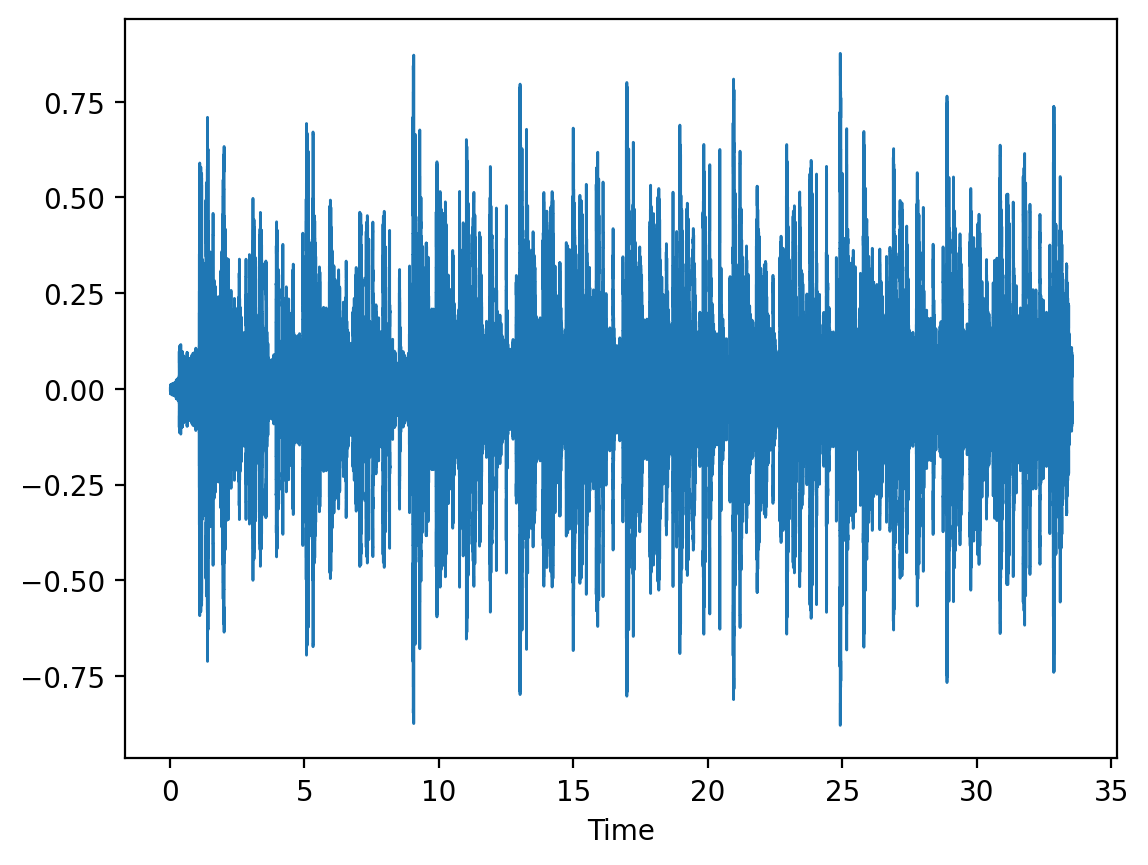

In [13]:
y, sr = librosa.load('a.wav')
librosa.display.waveshow(y, sr = sr)

#### Generating a power spectogram and converting it to a chroma representation

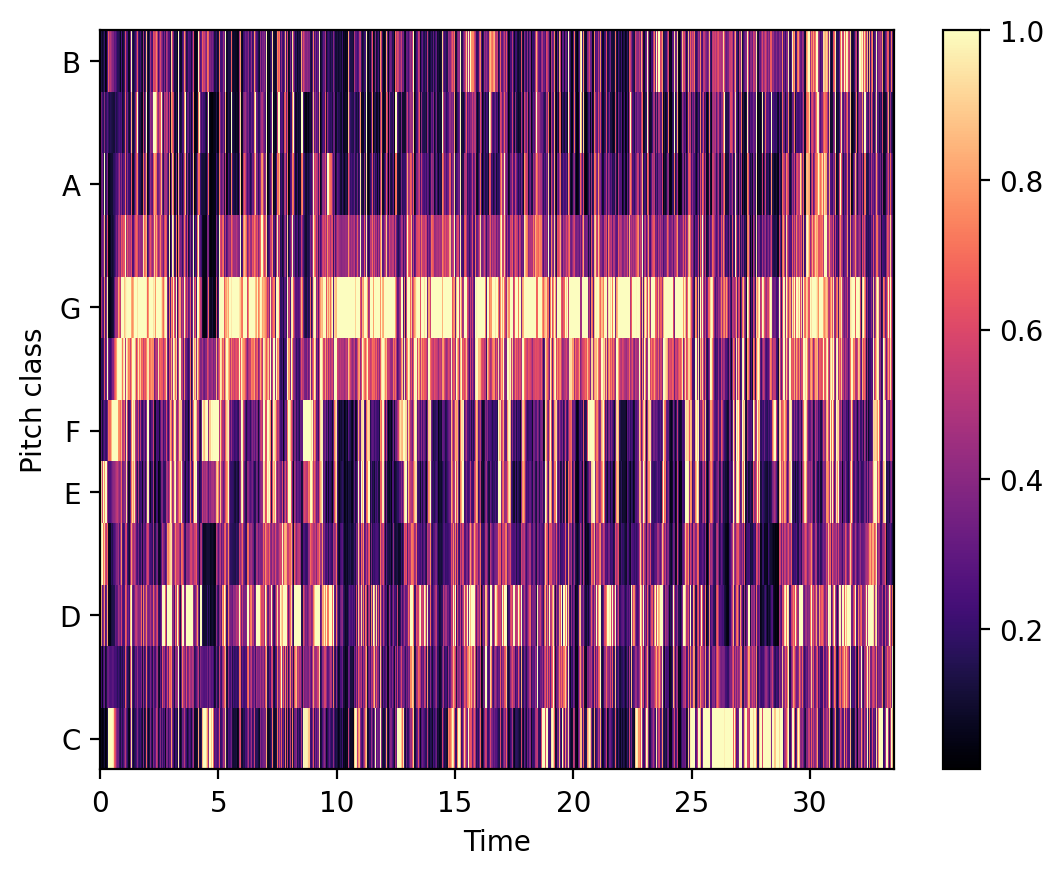

In [29]:
#A representaion of the power with which each chord is being played at a certain timestep
chroma = librosa.feature.chroma_stft(y = y, sr = sr)
import matplotlib.pyplot as plt
S = np.abs(librosa.stft(y))
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
fig.colorbar(img)

#### Problems with this method
- The problem with this kind of a representation is that the dataset that we finally work on is not compressed, and the features that we have extracted are meaningless. 
- To work on this kind of a dataset, we need to extract more meaningful features.
- As an alternative, we decided to target the chords of a song instead of the notes vs timestep.

***

### - Chord based extraction
- Each song in the dataset is a midi file.
- If we open a midi file, and read its content into a list, then on printing the list, we a get a list of meta messages describing the information related to the note being played with its velocity.
- This would be similar to what we did in the previous approach. In order to get more meaningful features, we use the technique of harmonic reduction, and get the chords of the songs (which repeat throughout the song.)

#### Function to open the midi file

In [30]:
def open_midi(midi_path, remove_drums):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()        
    return midi.translate.midiFileToStream(mf)

#### Harmonic reduction to extract chords of the song

In [32]:
def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        note_length = chord.quarterLength
        for note in chord.pitches:          
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length 
    return bass_note
                
def simplify_roman_name(roman_numeral):
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None):
        if (type(m) != stream.Measure):
            continue
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") 
            continue
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
    return ret

#### Helper functions to sort the order in which the directory is read

In [31]:
def getKey(f):
    res = re.search(r"(\d*)_(.*).mid",f)
    return int(res.group(1))*2+(0 if res.group(2)=="a" else 1)
def toKey(n):
    return 

#### Now we perform harmonic reduction on each song and add its chords to a corpus. A corpus in NLP techniques is a list storing all sentences in a project wherein we need to compute the similarity between the sentences.

In [33]:
corpus = []
iD = dict()
song = dict()
songList = []
for file in sorted(os.listdir('data2'), key = getKey):
    temp = open_midi(f'data2/{file}', True)
    h = harmonic_reduction(temp)
    s = " ".join(h)
    iD[s] = file
    song[file] = s
    songList.append(file)
    corpus.append(s)

#### Important notes
- Now that corpus is ready, we can use this as our dataset on the basis of which we will train our model.
- An interesting thing that we noted during the ideation phase of the project was that, once you convert the songs into their chord representation, it converts into a text similarity problem.
- Now the problem reduces to whether we can detect similarity between parts of a song which are now represented in text format.

***

### Main Algorithm

#### We will now combine two methods to work on the problem statement: 
- Candidate Generation
- Bidirectional LSTM

#### Candidate generation is the process of selection of songs from the corpus which are most similar to the song that was passed to the model as a query. Workflow:
- We use a sentence transformer to get the word embeddings. 
- Next, we work with faiss.IndexFlatL2(d) to generate an object 'index' containing vectors of dimension d to index.
- Now, the results of the first two are stacked with each other.
- Now that the index is ready, we search within it to find the k most similar songs to a given query.

In [34]:
embedder = SentenceTransformer('all-mpnet-base-v2')
corpus_embeddings = embedder.encode(corpus)
d= 768
index = faiss.IndexFlatL2(d)
index.add(np.stack(corpus_embeddings, axis=0))

As an example, let us take the song 4_a.mid from the dataset to check its candidates

In [74]:
queries = corpus[4]
query_embeddings = embedder.encode(queries)
k = 5
D, I = index.search(np.asarray(query_embeddings).reshape(1, 768), k)
relevant_songs = [corpus[I[0, idx]] for idx in range(k)]   
for idx in range(1, k): #We can ignore the first one as it will be the same as the song given as a query
    print(iD[corpus[I[0,idx]]], "(Distance: %.4f)" % D[0,idx])

print()
print("The given search finds the neighbours based on their distance from each other. This distance could be a measure such as Manhattan distance as well as Euclidean distance.")

4_b.mid (Distance: 0.3335)
12_b.mid (Distance: 0.8597)
11_b.mid (Distance: 0.8608)
9_b.mid (Distance: 0.9499)

The given search finds the neighbours based on their distance from each other. This distance could be a measure such as Manhattan distance as well as Euclidean distance.


***

#### Bidirectional LSTM is the process of making any neural network have the sequence information in both directions backwards or forward. It builds on what we already have using candidate generation to give better results.
- Note: We use another dataset based on the original dataset which gives us information on whether the pair of songs are plagiarised or not, in the form of binary classification (1 being yes, 0 being no). We use this dataset to train our Bidirectional LSTM.

In [62]:
dataset = pd.read_csv('dataset1.csv', header = None)

#making the data readable
arr = dataset.to_numpy()
arr = arr.tolist()
df2 = pd.DataFrame(columns = [])
df = pd.DataFrame(columns = ['song1', 'song2', 'chords1', 'chords2', 'label'])
for i in range(len(arr)):
    for j in range(i + 1, len(arr[0])):
        df.loc[len(df.index)] = [songList[i], songList[j], song[songList[i]], song[songList[j]], arr[i][j]]
df.head()

,song1,song2,chords1,chords2,label
0,1_a.mid,1_b.mid,i III65 ii42 iv V III65 ii iv43 VI7 vi42 i #vi...,i III65 ii42 iv V V i III65 ii42 iv V III6 #vi...,1
1,1_a.mid,2_a.mid,i III65 ii42 iv V III65 ii iv43 VI7 vi42 i #vi...,III III i III v,0
2,1_a.mid,2_b.mid,i III65 ii42 iv V III65 ii iv43 VI7 vi42 i #vi...,ii65 i42 i i42,0
3,1_a.mid,4_a.mid,i III65 ii42 iv V III65 ii iv43 VI7 vi42 i #vi...,i i i iv i i i i,0
4,1_a.mid,4_b.mid,i III65 ii42 iv V III65 ii iv43 VI7 vi42 i #vi...,i i i i i i,0


#### We need to divide all the sentences in the corpus into tokens, so that we can pass it to the word2vec model to get the word embeddings as numerical data vectors.

In [63]:
max_features = 1000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = max_features, lower = False)
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1

#### Making a model called word2vec and saving it in a file called word2vec.wordvectors

In [64]:
from gensim import models
w2v = gensim.models.Word2Vec([x.split(' ') for x in corpus], min_count = 1, vector_size = 100)
word2vec = w2v.wv
word2vec.save("word2vec.wordvectors")
wv = models.KeyedVectors.load("word2vec.wordvectors", mmap='r')

#### Now that the embeddings are ready, we can make a matrix out of it for ease of use while training the model.

In [65]:
embedding_matrix = zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    embedding_vector = w2v.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector[0]

#### Preparing the model

In [66]:
embedding_size = 128
max_len = 100

inp1 = Input(shape=(50,))
inp2 = Input(shape=(50,))

x1 = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=max_len)(inp1)
x2 = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=max_len)(inp2)

x3 = Bidirectional(LSTM(32, return_sequences = True))(x1)
x4 = Bidirectional(LSTM(32, return_sequences = True))(x2)

x5 = GlobalMaxPool1D()(x3)
x6 = GlobalMaxPool1D()(x4)

x7 =  dot([x5, x6], axes=1)

x8 = Dense(40, activation='relu')(x7)
x9 = Dropout(0.05)(x8)
x10 = Dense(10, activation='relu')(x9)
output = Dense(1, activation="sigmoid")(x10)

model = Model(inputs=[inp1, inp2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 256
epochs = 4

In [67]:
songs1 = tokenizer.texts_to_sequences(df['chords1'])
songs2 = tokenizer.texts_to_sequences(df['chords2'])
maxlen = 50
question_1_padded = pad_sequences(songs1, maxlen=maxlen)
question_2_padded = pad_sequences(songs2, maxlen=maxlen)

In [68]:
model.fit([question_1_padded, question_2_padded], df['label'], batch_size=batch_size, epochs=epochs, validation_split = 0.2)

Epoch 1/4
1/1 [==============================] - 9s 9s/step - loss: 0.6932 - accuracy: 0.0682 - val_loss: 0.6914 - val_accuracy: 0.8929
Epoch 2/4
1/1 [==============================] - 0s 273ms/step - loss: 0.6910 - accuracy: 0.9591 - val_loss: 0.6890 - val_accuracy: 0.8929
Epoch 3/4
1/1 [==============================] - 0s 287ms/step - loss: 0.6883 - accuracy: 0.9591 - val_loss: 0.6864 - val_accuracy: 0.8929
Epoch 4/4
1/1 [==============================] - 0s 289ms/step - loss: 0.6853 - accuracy: 0.9591 - val_loss: 0.6837 - val_accuracy: 0.8929


In [69]:
query = df['chords1'].values[100]
query_copy = [query] * len(corpus)
songs_1_sequenced_final = tokenizer.texts_to_sequences(query_copy)
songs_2_sequenced_final = tokenizer.texts_to_sequences(corpus)
print(iD[query])

4_a.mid


In [73]:
songs_1_padded_final = pad_sequences(songs_1_sequenced_final, maxlen = maxlen) 
songs_2_padded_final = pad_sequences(songs_2_sequenced_final, maxlen = maxlen)
prediction = model.predict([songs_1_padded_final, songs_2_padded_final])
prediction = np.array([x[0] for x in prediction])
matches = [iD[corpus[x]] for x in prediction.argsort()[::-1]][:5]
matches

['1_b.mid', '11_b.mid', '4_a.mid', '4_b.mid', '2_a.mid']

#### Conclusion
- From the list of matches, we see that '4_a.mid' is also included in the list, so that can be ignored. The next thing we need to keep in mind while building the LSTM is that the results differ at times, or even be inaccurate because the word2vec model could also generate faulty models at times (the frequency will be very low).
- In addition to this we can find the common elements from the list provided by Candidate Generation and Bidirectional LSTM and rank them on the basis of the distance given by Candidate Generation method.

### References
- https://www.kaggle.com/code/wfaria/midi-music-data-extraction-using-music21
- https://github.com/kavetinaveen/Deep-Learning-for-Semantic-Text-Matching/blob/main/NLP%20using%20Deep%20Learning%20in%20Python.ipynb